In [1]:
# in-built
import os
from pathlib import Path
from argparse import Namespace
from collections import defaultdict
from functools import partial


# torch
import torch
from torch import nn
from torch import optim

## other torch library
from torch.utils.data import (
    DataLoader,
    default_collate)
from torch.utils.data.backward_compatibility import worker_init_fn
from torchdata import datapipes as dp
from torchtext import vocab
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics
    from torchmetrics import Accuracy

# manipulation
import numpy as np

# visualization
import matplotlib.pyplot as plt

# others 
import gdown
from tqdm import tqdm

In [2]:
args = Namespace(
    # data 
    ## Flags
    download=False,
    use_split_dataset=True,
    url="https://drive.google.com/uc?export=download&id=1MBiOU5UCaGpJw2keXAqOLL8PCJg_uZaU",
    ## file and paths
    data_base_path = "../data/surnames/",
    file_name="surnames.csv",
    ## hyperparameter
    split_weights = {"train":0.7,"val":0.15,"test":0.15},
    
    # model 
    ## file and paths
    model_base_path = "../models/surnames/",
    model_file_name = "model.pth",
    ## hyper parameter
    hidden_dim = 300,
    
    # vocab
    unk_tkn = "@",
    
    # train
    seed = 1432,
    batch_size = 64,
    learning_rate = 0.001,
    num_epochs = 100,
    early_stopping_criteria = 5,
    
    
    # runtime option
    cuda = torch.cuda.is_available(),
    device = "cuda" if torch.cuda.is_available() else "cpu",
)


In [3]:
for key,value in args._get_kwargs():
    if key.endswith("path"):
        Path(value).mkdir(parents=True,exist_ok=True)

# Datapipes

## To split the full csv into train ,val ,test

In [4]:
def group_fn(row):
    return row[1]

def classification_fn(keys,row):
    return keys.index(row[1])

def meta_map(key,row):
    return (key,",".join(row))

def filename_fn(args,name):
    return os.path.join(args.data_base_path,os.path.basename(f"{name}.csv"))

In [5]:
stream = dp.iter.FileOpener([args.data_base_path+args.file_name])

# convert stream into row data.
row = stream.parse_csv(skip_lines=1)
# group the data based on the nationality yield the data chunk
nationality_group = row.groupby(group_key_fn=group_fn)

# count total number of group and row in each group
nation_count = defaultdict(int)
for nation in nationality_group:
    nation_count[nation[0][1]] += len(nation)
    
nation_count = dict(sorted(nation_count.items(),key=lambda kv:(kv[0],kv[1])))
nationality_keys = list(nation_count.keys())
torch.save(nation_count,args.data_base_path+"count.pth")

# divide the data pipe into multiple data pipe using demux
nation_demux = row.demux(num_instances=len(nationality_keys),
                            classifier_fn=partial(classification_fn,nationality_keys),
                            buffer_size=10000)

In [6]:
def split_full_csv(args):
    if args.download:
        # stream = dp.iter.GDriveReader([args.url])
        gdown.download(args.url,args.data_base_path+args.file_name,quiet=False)

    stream = dp.iter.FileOpener([args.data_base_path+args.file_name])
    
    # convert stream into row data.
    row = stream.parse_csv(skip_lines=1)
    # group the data based on the nationality yield the data chunk
    nationality_group = row.groupby(group_key_fn=group_fn)
    
    # count total number of group and row in each group
    nation_count = defaultdict(int)
    for nation in nationality_group:
        nation_count[nation[0][1]] += len(nation)
        
    nation_count = dict(sorted(nation_count.items(),key=lambda kv:(-kv[1],kv[0])))
    nationality_keys = list(nation_count.keys())
    torch.save(nation_count,args.data_base_path+"count.pth")
    
    # divide the data pipe into multiple data pipe using demux
    nation_demux = row.demux(num_instances=len(nationality_keys),
                             classifier_fn=partial(classification_fn,nationality_keys),
                             buffer_size=10000)
    
    dataset = {k:dp.iter.IterableWrapper([])
               for k in args.split_weights.keys()}
    
    for key_name in dataset.keys():
        for idx,nation_child_pipe in enumerate(nation_demux):
            target = nation_child_pipe.random_split(weights=args.split_weights,
                                                    seed=args.seed,
                                                    total_length=nation_count[nationality_keys[idx]],
                                                    target=key_name)            
            dataset[key_name] = dataset[key_name].concat(target)
        
        meta_dp = dataset[key_name].map(partial(meta_map,key_name))
        para_dp = meta_dp.lines_to_paragraphs(joiner=lambda ls:"\n".join(ls))
        saver_dp = para_dp.save_to_disk(filepath_fn=partial(filename_fn,args))
        print(list(saver_dp))
    
    return nation_count,dataset

In [7]:
def get_dataset(args):
    if args.use_split_dataset:
        print(f"[INFO] Loading the dataset from files")
        dataset = {fname:dp.iter.FileOpener([args.data_base_path+fname+".csv"]).parse_csv()
                   for fname in args.split_weights.keys()}
        nation_count = torch.load(args.data_base_path+"count.pth")
        return nation_count,dataset
            
    else:
        print(f"[INFO] Splitting dataset into train,val,test and storing locally")
        return split_full_csv(args)

In [8]:
nation_count,dataset_pipes = get_dataset(args)

[INFO] Loading the dataset from files


In [9]:
def surname_token_fn(row):
    return row[0]

def nationality_token_fn(row):
    return [row[1]]

def create_dataset(surname_vocab,nation_vocab,row):
    surname_vector = np.zeros(shape=len(surname_vocab),dtype=np.float32)
    surname_vector[surname_vocab.lookup_indices(list(surname_token_fn(row)))] = 1
    
    nation_index = nation_vocab.lookup_indices([row[1]])[-1]
    return {"x":surname_vector,
            "y":nation_index}

def collate_fn(args,x):
    return {k:v.to(args.device)
            for x_ in default_collate(x)
            for k,v in x_.items()}

In [10]:
def built_vocab_dict(dataset,args):
    train_dataset = dataset["train"]
    surname_token = train_dataset.map(surname_token_fn)
    surname_vocab = vocab.build_vocab_from_iterator(surname_token,
                                                    specials=[args.unk_tkn])
    surname_vocab.set_default_index(surname_vocab[args.unk_tkn])
    
    nationality_token = train_dataset.map(nationality_token_fn)
    nationality_vocab = vocab.build_vocab_from_iterator(nationality_token)
    
    return {"surname":surname_vocab,
            "nationality":nationality_vocab}

In [11]:
def build_dataset_dict(dataset,vocab,args):
    dataset_dict = defaultdict()
    fn = partial(create_dataset,vocab["surname"],vocab["nationality"])
    for key_name in args.split_weights.keys():
        if key_name == "train":
            datapipe = dataset[key_name].shuffle().sharding_filter()
        else:
            datapipe = dataset[key_name]
        dataset_dict[key_name] = datapipe.map(fn).batch(args.batch_size,drop_last=True)
    return dataset_dict

In [12]:
vocab_dict = built_vocab_dict(dataset=dataset_pipes,
                              args=args)
dataset_dict = build_dataset_dict(dataset=dataset_pipes,
                                  vocab=vocab_dict,
                                  args=args)

In [13]:
def generate_batches(dataset,args=args,shuffle=False):
    dataloader = DataLoader(dataset=dataset,
                            batch_size=args.batch_size,
                            shuffle=shuffle,
                            worker_init_fn=worker_init_fn,
                            collate_fn=partial(collate_fn,args))
    for batch in dataloader:
        yield batch

# Model

In [35]:
class SurnameClassifier(nn.Module):
    def __init__(self,input_dim,hidden_dim,out_dim) -> None:
        super().__init__()
        self.fc1 = nn.Linear(in_features=input_dim,
                             out_features=hidden_dim)
        self.fc2 = nn.Linear(in_features=hidden_dim,
                             out_features=out_dim)
        
    def forward(self,input,apply_softmax=False):
        intermediate = torch.relu(self.fc1(input))
        logits = self.fc2(intermediate)
        
        if apply_softmax:
            logits = torch.softmax(logits,dim=1)
        
        return logits

# Training

## Helper function

In [15]:
def make_train_state(args=args):
    return {"stop_early":False,
            "early_stopping_step":0,
            "early_stopping_val":1e8,
            "epoch_index":0,
            "learning_rate":args.learning_rate,
            "model_filename":args.model_base_path+args.model_file_name,
            "train_loss":[],
            "train_acc":[],
            "val_loss":[],
            "val_acc":[],
            "test_loss":-1,
            "test_acc":-1}
    

def update_train_state(train_state,model,args=args):
    if train_state["epoch_index"] == 0:
        torch.save(model.state_dict(),train_state["model_filename"])
        train_state["stop_early"] = False
        
    elif train_state["epoch_index"] >= 1:
        loss_tm1,loss_t = train_state["val_loss"][-2:]
        
        if loss_t >= train_state["early_stopping_val"]:
            train_state["early_stopping_step"] += 1
        
        else:
            torch.save(model.state_dict(),train_state["model_filename"])
            train_state["stop_early"] = 0
        
        train_state["stop_early"] = train_state["early_stopping_step"] >= args.early_stopping_criteria
    
    return train_state

In [16]:
def set_seed_everywhere(seed,cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)
        
set_seed_everywhere(args.seed,args.cuda)

## initialize

In [17]:
class_weights = 1.0/torch.tensor(list(nation_count.values()),dtype=torch.float32).to(args.device)

In [18]:
classifier = SurnameClassifier(input_dim=len(vocab_dict["surname"]),
                               hidden_dim=args.hidden_dim,
                               out_dim=len(vocab_dict["nationality"])).to(args.device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
acc_fn = Accuracy(task="multiclass",num_classes=len(class_weights)).to(args.device)
optimizer = optim.Adam(params=classifier.parameters(),
                       lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode="min",factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

## Training Loop

In [19]:
for epoch_index in tqdm(range(args.num_epochs)):
    train_state["epoch_index"] = epoch_index
    
    # init the running variable
    running_loss = 0.0
    running_acc = 0.0
    
    # get the train dataloader
    batch_generator = generate_batches(dataset=dataset_dict["train"],
                                       args=args,shuffle=True)
    
    # put the model in training mode
    classifier.train()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        optimizer.zero_grad()
        logits = classifier(batch_dict["x"])
        # compute the loss per batch
        loss = loss_fn(logits,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (batch_idx+1)
        
        # compute the acc per batch
        acc = acc_fn(logits,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
        loss.backward()
        
        optimizer.step()
        
    train_state["train_loss"].append(running_loss)
    train_state["train_acc"].append(running_acc)
    
    # iterate over the val dataset
    
    # init the running variable
    running_loss = 0.0
    running_acc = 0.0
    
    # get the val dataloader
    batch_generator  = generate_batches(dataset=dataset_dict["val"],
                                        args=args,shuffle=False)
    
    # put the model in eval mode
    classifier.eval()
    
    for batch_idx,batch_dict in enumerate(batch_generator):
        with torch.inference_mode():
            logits = classifier(batch_dict["x"])
            
            # compute the loss
            loss = loss_fn(logits,batch_dict["y"])
            loss_t = loss.item()
            running_loss += (loss_t-running_loss) /(batch_idx+1)
            
            # compute the acc
            acc = acc_fn(logits,batch_dict["y"])
            acc_t = acc.item()
            running_acc += (acc_t-running_acc) /(batch_idx+1)
            
    train_state["val_loss"].append(running_loss)
    train_state["val_acc"].append(running_acc)
    
    
    train_state = update_train_state(train_state=train_state,
                                     model=classifier,
                                     args=args)
    
    scheduler.step(train_state["val_loss"][-1])
    if train_state["stop_early"]:
        break          

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


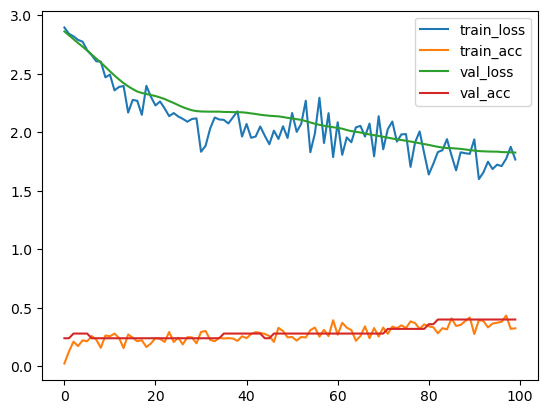

In [20]:
plt.plot(train_state["train_loss"],label="train_loss")
plt.plot(train_state["train_acc"],label="train_acc")
plt.plot(train_state["val_loss"],label="val_loss")
plt.plot(train_state["val_acc"],label="val_acc")
plt.legend();

## test

In [37]:
classifier = SurnameClassifier(input_dim=len(vocab_dict["surname"]),
                               hidden_dim=args.hidden_dim,
                               out_dim=len(vocab_dict["nationality"])).to(args.device)

In [38]:
classifier.load_state_dict(torch.load(train_state["model_filename"],
                                      map_location=torch.device(args.device)))

<All keys matched successfully>

In [23]:
batch_generator = generate_batches(dataset=dataset_dict["test"],
                                   args=args,shuffle=False)

running_acc = 0.0
running_loss = 0.0
classifier.eval()

for batch_idx,batch_dict in enumerate(batch_generator):
    with torch.inference_mode():
        logits = classifier(batch_dict["x"])
        
        # compute the loss
        loss = loss_fn(logits,batch_dict["y"])
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) /(batch_idx+1)
        
        # compute the acc
        acc = acc_fn(logits,batch_dict["y"])
        acc_t = acc.item()
        running_acc += (acc_t - running_acc) / (batch_idx+1)
        
train_state["test_loss"] = running_loss
train_state["test_acc"] = running_acc

In [24]:
print(f"Test Loss : {train_state['test_loss']}")
print(f"Test Acc : {train_state['test_acc']:.2%}")

Test Loss : 1.6335911750793457
Test Acc : 44.00%


# Inference

In [29]:
def vectorize(surname,surname_vocab):
    surname_vector = np.zeros(shape=len(surname_vocab),dtype=np.float32)
    surname_vector[surname_vocab.lookup_indices(list(surname))] = 1
    return surname_vector

In [26]:
def predict_nationality(surname,classifier,vocab_dict):
    surname_vector = torch.tensor(vectorize(surname,vocab_dict["surname"]),
                                  dtype=torch.float32).view(1,-1)
    result = classifier(surname_vector,apply_softmax=True)
    prob,indices = result.max(dim=1)
    
    
    pred_nationality = vocab_dict["nationality"].lookup_token(indices)
    
    

In [55]:
surname = "Hinton"

In [56]:
surname_vector = torch.tensor(vectorize(surname,vocab_dict["surname"])).view(1,-1)

In [57]:
result = classifier(surname_vector,apply_softmax=True)

In [58]:
prob,indices = result.max(dim=1)

In [59]:
vocab_dict["nationality"].lookup_token(indices)

'Russian'